In [1]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat, lit, to_timestamp, year, month, dayofmonth, to_date, date_format
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
yellow_19 = spark.read.load('Downloads/NYC-Yellow-Taxi-Spark-Streaming-main1/NYTaxiDataset/source/2019_Yellow_Taxi_Trip_Data.csv',format='csv', sep=',', inferSchema='true', header='true')
yellow_20 = spark.read.load('Downloads/NYC-Yellow-Taxi-Spark-Streaming-main1/NYTaxiDataset/source/2020_Yellow_Taxi_Trip_Data.csv',format='csv', sep=',', inferSchema='true', header='true')
yellow_21 = spark.read.load('Downloads/NYC-Yellow-Taxi-Spark-Streaming-main1/NYTaxiDataset/source/2021_Yellow_Taxi_Trip_Data.csv',format='csv', sep=',', inferSchema='true', header='true')

In [4]:
data = yellow_19.union(yellow_20.union(yellow_21))

In [4]:
data.dtypes

[('_c0', 'int'),
 ('VendorID', 'double'),
 ('tpep_pickup_datetime', 'string'),
 ('tpep_dropoff_datetime', 'string'),
 ('passenger_count', 'double'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'double'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'double'),
 ('DOLocationID', 'double'),
 ('payment_type', 'double'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double'),
 ('LocationID', 'int'),
 ('Borough', 'string'),
 ('Zone', 'string'),
 ('service_zone', 'string')]

In [5]:
data = data.withColumn("tpep_pickup_datetime", to_timestamp(col("tpep_pickup_datetime"), "MM/dd/yyyy hh:mm:ss a"))
data = data.withColumn("tpep_dropoff_datetime", to_timestamp(col("tpep_dropoff_datetime"), "MM/dd/yyyy hh:mm:ss a"))
data = data.withColumn("date", to_date(col("tpep_pickup_datetime")))
data = data.withColumn("time", date_format('tpep_pickup_datetime', 'HH:mm:ss'))
data = data.withColumn("hour", date_format('tpep_pickup_datetime', 'HH'))
data = data.withColumn("weekday", date_format(col("tpep_pickup_datetime"), "EEEE"))
data = data.withColumn('duration',(unix_timestamp("tpep_dropoff_datetime") - unix_timestamp('tpep_pickup_datetime'))/ 60)
data = data.withColumn("tip_percent", col("tip_amount")/ col("total_amount") * 100)
data = data.withColumn("year", year(data.date))

In [6]:
data.show()

+---+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+----------+---------+-------------------+------------+----------+--------+----+--------+------------------+------------------+----+
|_c0|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|LocationID|  Borough|               Zone|service_zone|      date|    time|hour| weekday|          duration|       tip_percent|year|
+---+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+------

In [7]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- VendorID: double (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: double (nullable = true)
 |-- DOLocationID: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: s

In [8]:
data = data.drop("_c0")

In [9]:
data.printSchema()

root
 |-- VendorID: double (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: double (nullable = true)
 |-- DOLocationID: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)
 |-- date: d

In [10]:
## Registering dataframe as a Table


sqlCtx.registerDataFrameAsTable(data, "nyc_taxi_data")

In [35]:
df1 = sqlCtx.sql("SELECT Borough, avg(total_amount) as total_amount from nyc_taxi_data where Borough != 'EWR' group by Borough;")
df2 = sqlCtx.sql("SELECT Borough, avg(tip_percent) as avg_tip from nyc_taxi_data where Borough != 'EWR' group by Borough;")
df3 = sqlCtx.sql("SELECT Borough, avg(duration) as avg_duration from nyc_taxi_data where Borough != 'EWR' group by Borough;")
df4 = sqlCtx.sql("SELECT Borough, avg(trip_distance) as avg_dist from nyc_taxi_data where Borough != 'EWR' group by Borough;")

In [12]:
df1.show()

+-------------+------------------+
|      Borough|      total_amount|
+-------------+------------------+
|    Manhattan| 16.91584707894637|
|       Queens| 46.45784964778371|
|      Unknown| 29.78353307953493|
|     Brooklyn|27.909377296284955|
|Staten Island| 79.79085361093001|
|        Bronx| 32.65105195626656|
+-------------+------------------+



In [36]:
#s1 = df1.sample(False, 0.05, 20)
df1 = df1.toPandas()
df2 = df2.toPandas()
df3 = df3.toPandas()
df4 = df4.toPandas()

<AxesSubplot:xlabel='Borough', ylabel='total_amount'>

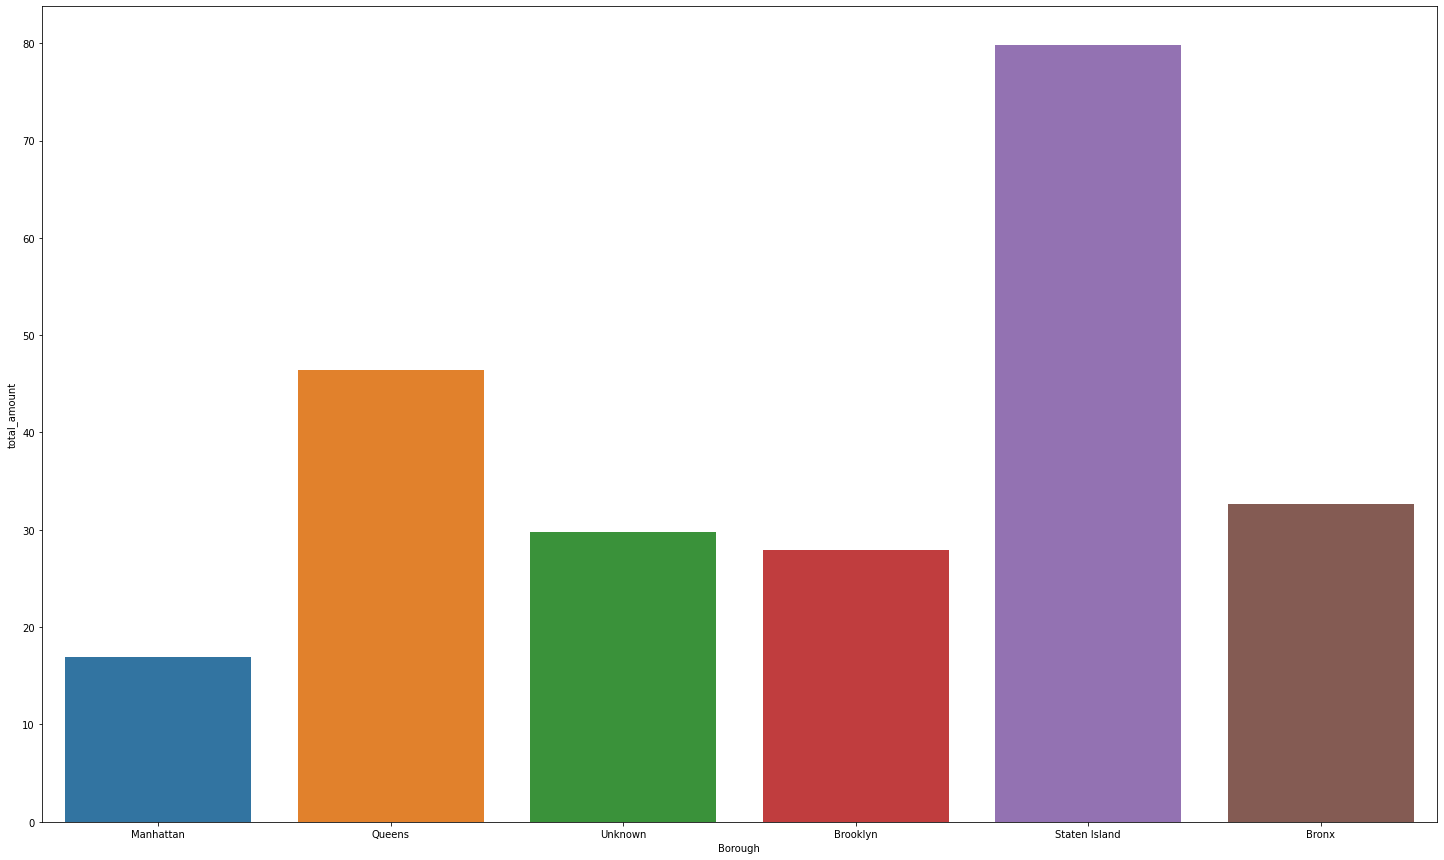

In [37]:
#fig = px.bar(s1, x="Zone", y="total_fare")
fig = plt.figure(figsize = (25, 15))
sns.barplot(x = 'Borough', y = 'total_amount', data = df1)

<AxesSubplot:xlabel='Borough', ylabel='avg_tip'>

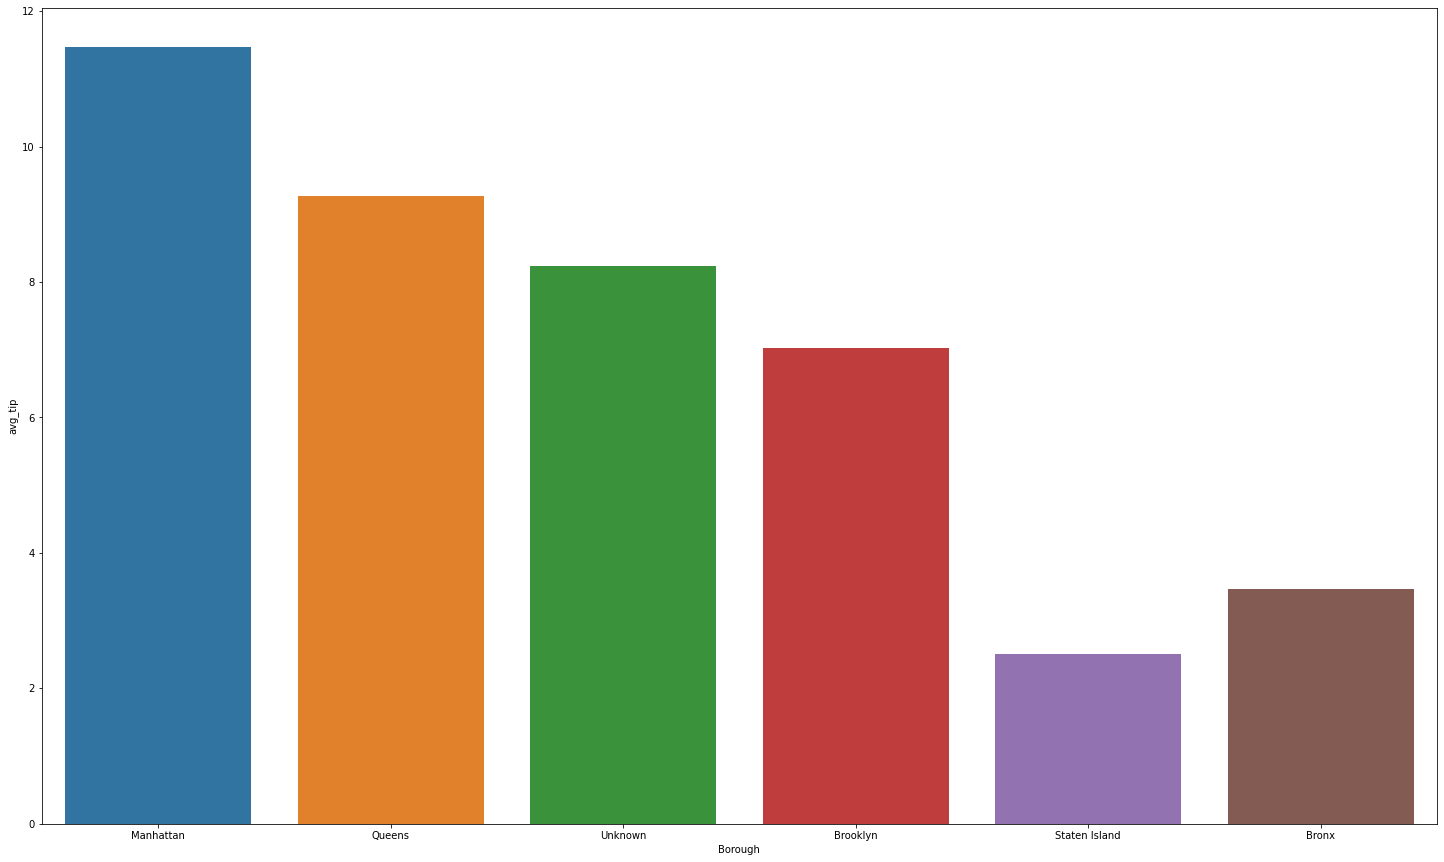

In [38]:
#fig = px.bar(s1, x="Zone", y="total_fare")
fig = plt.figure(figsize = (25, 15))
sns.barplot(x = 'Borough', y = 'avg_tip', data = df2)

<AxesSubplot:xlabel='Borough', ylabel='avg_duration'>

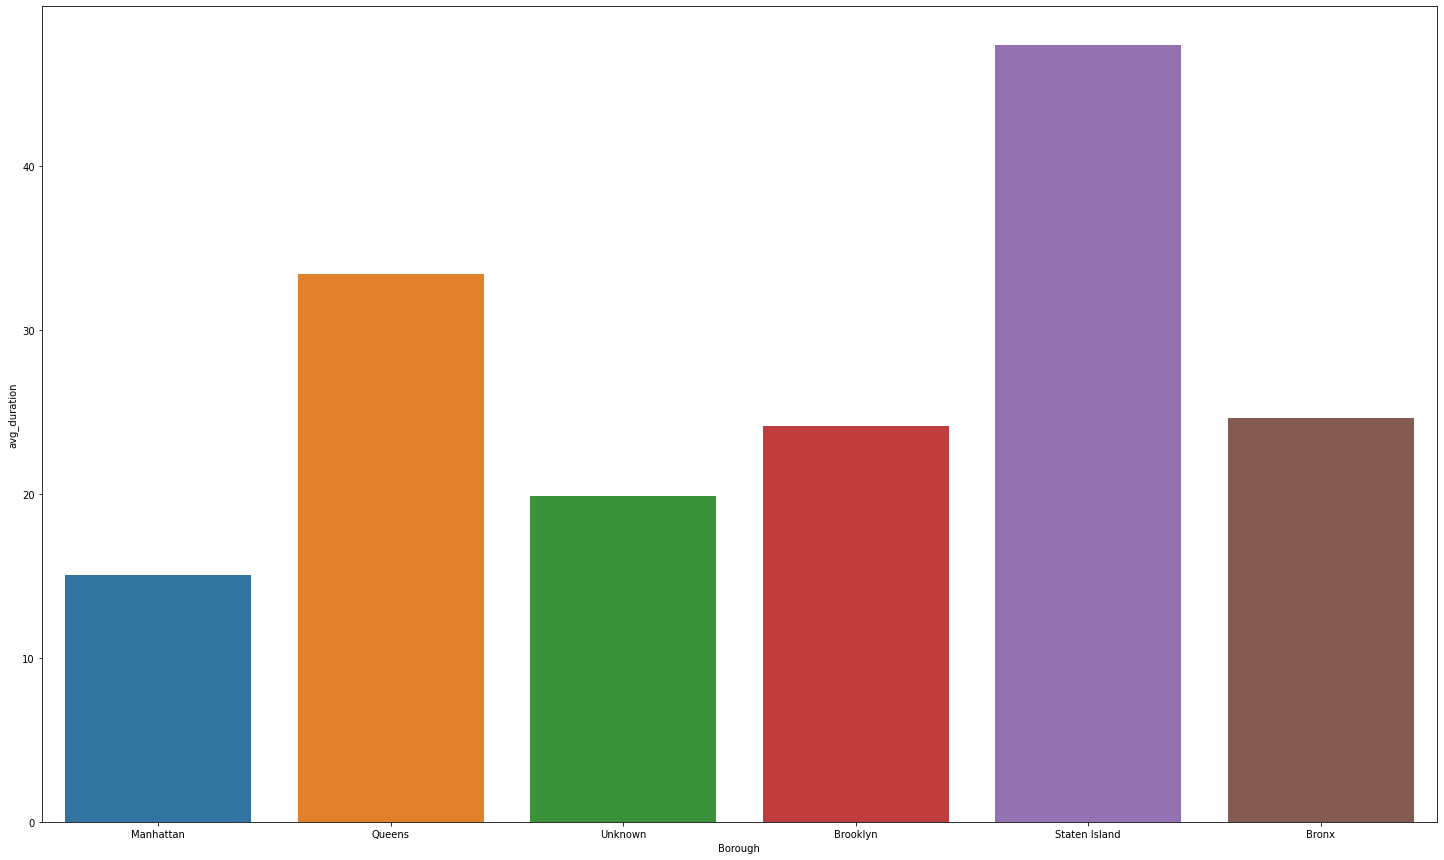

In [39]:
#fig = px.bar(s1, x="Zone", y="total_fare")
fig = plt.figure(figsize = (25, 15))
sns.barplot(x = 'Borough', y = 'avg_duration', data = df3)

<AxesSubplot:xlabel='Borough', ylabel='avg_dist'>

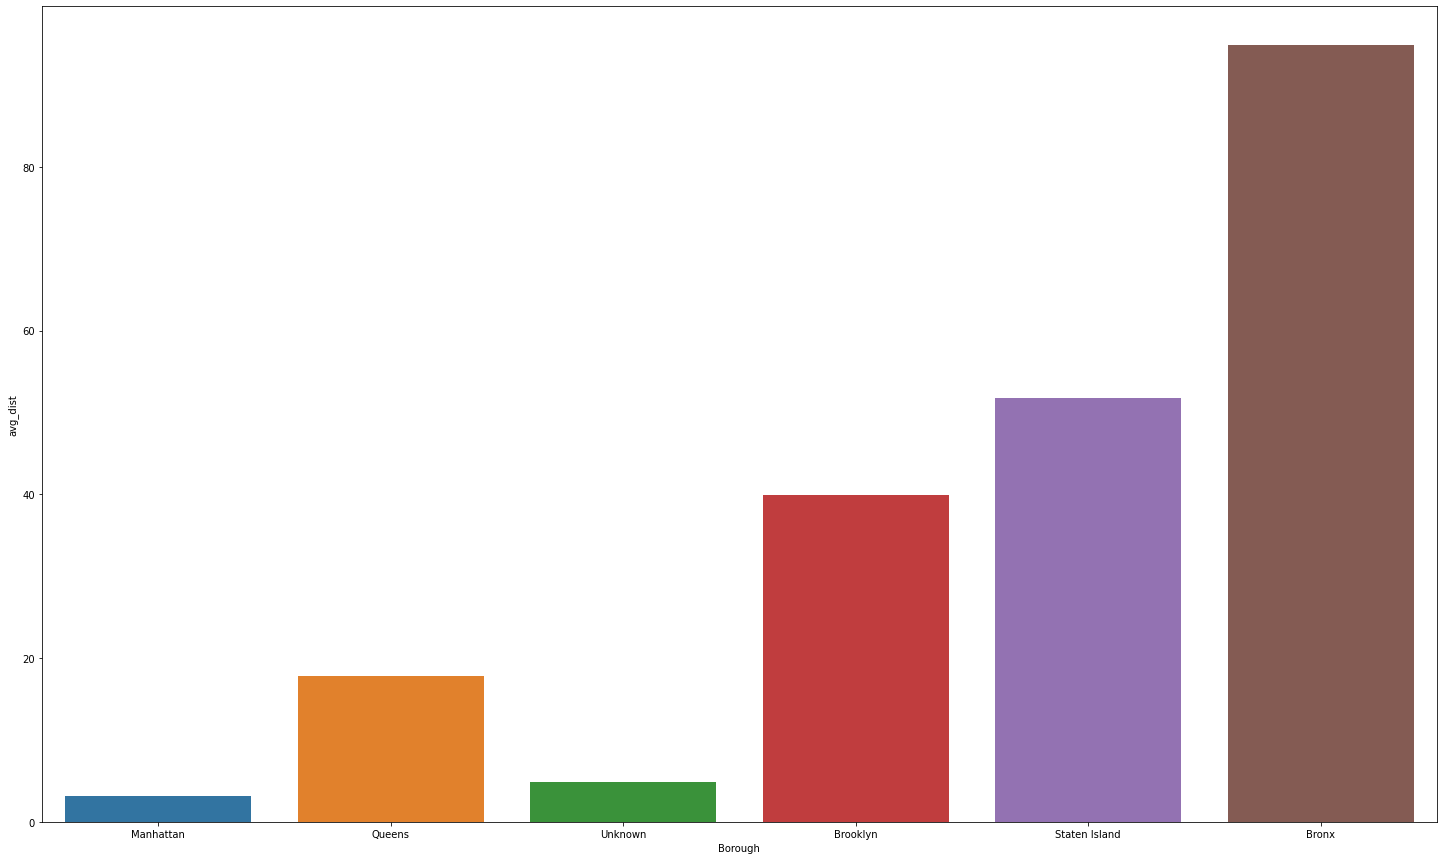

In [40]:
#fig = px.bar(s1, x="Zone", y="total_fare")
fig = plt.figure(figsize = (25, 15))
sns.barplot(x = 'Borough', y = 'avg_dist', data = df4)

In [22]:
df5 = sqlCtx.sql("SELECT hour, avg(tip_percent) as avg_tip_percent from nyc_taxi_data where Borough != 'EWR' group by hour;")

In [23]:
df5.show()

+----+------------------+
|hour|   avg_tip_percent|
+----+------------------+
|  07|11.178048740750981|
|  15|10.908171929935603|
|  11|10.896793070879118|
|  01|10.931079743822671|
|  22|11.826083236999937|
|  16| 10.97407438332724|
|  18|11.649819607321266|
|  00|11.159074796208555|
|  17|11.368205606385805|
|  09|11.317792421884828|
|  05| 8.921531786273674|
|  19|11.679142531315009|
|  23|11.409977783185303|
|  08|11.586248322035331|
|  03| 9.932457264437225|
|  02|10.633407687132426|
|  06|10.119914402585415|
|  20|11.737903047739763|
|  10|10.988481944317831|
|  12|10.892422009657349|
+----+------------------+
only showing top 20 rows



In [24]:
df5 = df5.toPandas()

In [25]:
df5 = df5.sort_values(by=['hour'])

<AxesSubplot:xlabel='hour'>

<Figure size 1800x1080 with 0 Axes>

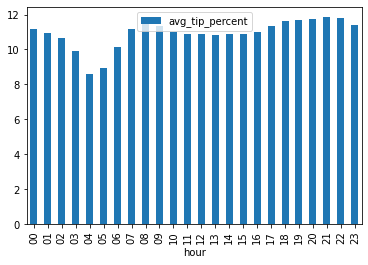

In [27]:
fig = plt.figure(figsize = (25, 15))

df5.plot.bar(x = 'hour', y = 'avg_tip_percent')
#sns.barplot(x = 'hour', y = 'avg_tip', data = df5)

In [29]:
df6 = sqlCtx.sql("SELECT hour, count(*) as count from nyc_taxi_data where Borough != 'EWR' group by hour;")

In [30]:
df6 = df6.toPandas()

In [31]:
df6 = df6.sort_values(by=['hour'])

In [33]:
df6

,hour,count
7,00,1502563
3,01,998876
15,02,667445
14,03,460288
20,04,365299
10,05,472520
16,06,1193720
0,07,2153779
13,08,2864854
9,09,3059497


<AxesSubplot:xlabel='hour'>

<Figure size 1800x1080 with 0 Axes>

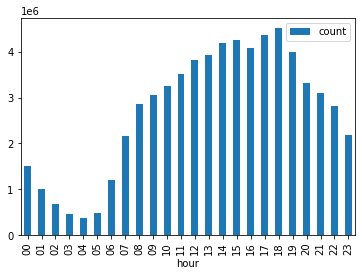

In [34]:
fig = plt.figure(figsize = (25, 15))

df6.plot.bar(x = 'hour', y = 'count')